# Демонстрация автоматического отбора признаков с помощью Permutation Importance

## Структура ноутбука:
- Применение библиотеки Permutation Importance для задач классификации
    * Проверка Permutation Importance на доступных алгоритмах
    * Проверка всех библиотек Permutation Importance (sklearn, eli5, собственный kib) на CatBoostClassifier   

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, mean_absolute_percentage_error

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, PermutationSelection, base_pipe

* sklearn:  0.24.2
* xgboost:  1.5.2
* matplotlib:  3.1.1
* autobinary:  1.0.3

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  0.24.2
xgboost:  1.5.2
matplotlib:  3.1.0
autobinary:  1.0.4


In [5]:
import numpy as np
np.__version__

'1.22.4'

In [6]:
import scipy
scipy.__version__

'1.8.1'

In [7]:
# eli5==0.13.0

In [8]:
sample = pd.read_csv('../data/train_titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [9]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

features = num_columns+cat_columns

target = ['Survived']

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
    sample[features],
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [11]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns, 
    kind='all')

In [12]:
prep_pipe.fit(X_train, y_train)

new_X_train = prep_pipe.transform(X_train)
new_X_valid = prep_pipe.transform(X_valid)

# 1. Использование библиотеки Auto Permutation

#### Проверка на нескольких моделях 

* Для выбора оптимального алгоритма, можно запустить метод на различных моделях бустинга, деревьев. Задаются словари параметров, листы со словарями и названием моделей. 

In [13]:
# Определение стандартных гиперпараметров моделей и список моделей

params_xgb = {'eta':0.01,
              'n_estimators':500,
              'subsample':0.9,
              'max_depth':6,
              'objective':'binary:logistic',
              'n_jobs':-1,
              'random_state':42,
              'eval_metric':'logloss'}

params_ctb = {'learning_rate':0.01,
              'iterations':500,
              'subsample':0.9,
              'depth':6,
              'loss_function':'Logloss',
              'thread_count':-1,
              'random_state':42,
              'verbose':0}

params_lgb = {'learning_rate':0.01,
              'n_estimators':500,
              'subsample':0.9,
              'max_depth':6,
              'objective':'binary',
              'metric':'binary_logloss',
              'n_jobs':-1,
              'random_state':42,
              'verbose':-1}

params_dt = {'criterion':'gini',
             'max_depth':6,
             'random_state':42}

params_rf = {'criterion':'gini',
             'max_depth':6,
             'random_state':42,
             'n_estimators':500}

params_list = [params_xgb, 
               params_ctb, 
               params_lgb, 
               params_dt, 
               params_rf
              ]

models_list = ['xgboost', 
               'catboost', 
               'lightboost', 
               'decisiontree', 
               'randomforest'
              ] 

### 1.1. Определяем класс PermutationSelection, куда передаем список из словарей параметров, список моделей, а также задаем тип задачи: "classification"/"multiclassification"/"regression"

* Далее запускаем метод обучения fit, куда передаем тренировочное множество (фолд из тренировочного множества, при больших выборках), и целевую переменную.


* Далее запускае метод calculate_permutation. Это основной метод для расчета метрик при перемешивании факторов. В метод передается тестовое множество (независимый фолд из тренировочного множества, при больших выборках), целевую переменную для тестового множества, количество перемешиваний фактора, способ Permutation Importance ("eli5"/"sklearn"/"kib"). Для более подробного описания метода, можно вызвать функцию shift+tab


* Все запускается циклом, для отбора более быстрого оптимального алгоритма.
    * Запуск требуется по желанию, если есть независимые фолды маленьких размеров.
    * Данный цикл является примером работы на всех доступных алгоритмах.

In [14]:
# Применение самописной библиотеки Permutation Importance (kib)

features_dict=dict()

for i in range(len(params_list)):
    
    perm_imp = PermutationSelection(
        model_type=models_list[i], 
        model_params=params_list[i], 
        task_type='classification')
    
    perm_imp.fit(
        X_train=new_X_train,
        y_train=y_train)
    
    perm_imp.calculate_permutation(
        X_test=new_X_valid, 
        y_test=y_valid,
        n_iter=5,
        permute_type='kib',
        n_jobs=-1,
        metric=roc_auc_score,
        higher_is_better=True)
    
    print('Модель: ', models_list[i],'\n')
    features_dict[models_list[i]] = perm_imp.select_features()
    print()

Расчет Permutation Importance на Train


100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 312.12it/s]


Расчет Permutation Importance на Test


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4326.81it/s]


Модель:  xgboost 

8 признаков было до Permutation Importance 

4 признаков после Permutation Importance от kib

Расчет Permutation Importance на Train


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7253.44it/s]


Расчет Permutation Importance на Test


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 5308.41it/s]


Модель:  catboost 

8 признаков было до Permutation Importance 

5 признаков после Permutation Importance от kib

Расчет Permutation Importance на Train


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 5024.62it/s]


Расчет Permutation Importance на Test


100%|██████████████████████████████████████████| 8/8 [00:00<00:00, 12386.28it/s]


Модель:  lightboost 

8 признаков было до Permutation Importance 

4 признаков после Permutation Importance от kib

Расчет Permutation Importance на Train


100%|██████████████████████████████████████████| 8/8 [00:00<00:00, 19373.23it/s]


Расчет Permutation Importance на Test


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9915.61it/s]

Модель:  decisiontree 

8 признаков было до Permutation Importance 

6 признаков после Permutation Importance от kib



Расчет Permutation Importance на Train


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4728.64it/s]


Расчет Permutation Importance на Test


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7086.47it/s]


Модель:  randomforest 

8 признаков было до Permutation Importance 

6 признаков после Permutation Importance от kib



* После обучения моделей получаем словари факторов для каждого из алгоритмов. Также можно отследить скорость обучения и выбрать подходящий для нас алгоритм

In [15]:
features_dict

{'xgboost': ['Sex', 'Pclass', 'Age', 'Fare'],
 'catboost': ['Sex', 'Pclass', 'Age', 'Fare', 'Parch'],
 'lightboost': ['Sex', 'Pclass', 'Age', 'Parch'],
 'decisiontree': ['Sex', 'Pclass', 'Fare', 'Age', 'Parch', 'SibSp'],
 'randomforest': ['Sex', 'Pclass', 'Age', 'Parch', 'Fare', 'Embarked']}

* После анализа цикла, выбираем лучший алгоритм относительно скорость / качество. В нашем случае выбор выберем catboost и покажем на его примере.

## 2. Отбор признаков с помощью углубления древовидных алгоритмов

### 2.1. Задаем класс PermutationSelection. Передаем выборанный нами алгоритм, словарь параметров алгоритмы, а также тип решаемой задачи (покажем на примере catboost)

In [16]:
models_list[1]

'catboost'

In [17]:
params_list[1]

{'learning_rate': 0.01,
 'iterations': 500,
 'subsample': 0.9,
 'depth': 6,
 'loss_function': 'Logloss',
 'thread_count': -1,
 'random_state': 42,
 'verbose': 0}

In [18]:
perm_imp = PermutationSelection(
    model_type=models_list[1], 
    model_params=params_list[1], 
    task_type='classification')

### 2.2. Метод depth_analysis используется для отбора факторов относительно глубины алгоритма.

* В параметры передаются тренировочная выборка (фолд из тренировочной выборки), целевая переменная, список факторов и максимальная глубина до которой будут расчитываться важности признаков.


* На выходе мы получаем таблицу из факторов отсортированных по важности, таблицу из факторов отрсортированных по рангу признака, список факторов из отсортированных по важности, список факторов из отсортированных по рангу.


    * Аргоритм отбора относительно глубины: модель обучается на всех факторах в цикле с глубиной от 1 до максимально указанной. Далее выводятся важности по каждому признаку в каждой глубине. После чего значение усредняется по каждому признаку и сортируется по убыванию.
    
    * Алгоритм отбора относительно ранга в глубине: аналогично предыдущему, только при каждом значении глубины отбираются признаки со значением важности >0, по ним расставляются ранговые значения, и расчитывается среднее внутри каждой глубины. После чего ранги усредняются относительно глубин и сортируются по убыванию.

In [19]:
fi, fi_rank, depth_features, rank_features = perm_imp.depth_analysis(
    new_X_train, 
    y_train, 
    features,
    5)

  0%|          | 0/5 [00:00<?, ?it/s]

Количество признаков до отбора: 7
Количество признаков после mean importance относительно глубины: 7
Количество признаков после mean rank относительно глубины: 7


In [20]:
# Таблица важностей признаков относительно глубины

fi

,importance_depth_1,importance_depth_2,importance_depth_3,importance_depth_4,importance_depth_5,mean_importance,mean_rank
Sex,69.132379,54.531447,46.890808,41.767536,39.064884,50.277411,0.250000
Pclass,17.312772,19.878804,19.535158,18.840982,17.355804,18.584704,0.214286
Fare,8.416001,11.404890,10.649492,11.394727,12.570966,10.887215,0.164286
Age,0.457816,5.048347,10.250971,12.661793,12.940829,8.271951,0.135714
SibSp,2.470971,4.807983,6.260858,6.349496,6.757650,5.329392,0.107143
Parch,1.066115,2.753890,4.295561,6.093492,7.507391,4.343290,0.078571
Embarked,1.143946,1.574639,2.117151,2.891973,3.802475,2.306037,0.050000


In [21]:
# Таблица рангов признаков относительно глубины

fi_rank

,rank_depth_1,rank_depth_2,rank_depth_3,rank_depth_4,rank_depth_5,mean_rank
index,,,,,,
Sex,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
Pclass,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286
Fare,0.178571,0.178571,0.178571,0.142857,0.142857,0.164286
Age,0.035714,0.142857,0.142857,0.178571,0.178571,0.135714
SibSp,0.142857,0.107143,0.107143,0.107143,0.071429,0.107143
Parch,0.071429,0.071429,0.071429,0.071429,0.107143,0.078571
Embarked,0.107143,0.035714,0.035714,0.035714,0.035714,0.050000


In [22]:
# Обновляем признаки после отбора по важностям или рангу относительно глубины

new_num_columns = list(filter(lambda x: x in num_columns, depth_features))
new_cat_columns = list(filter(lambda x: x in cat_columns, depth_features))

# 3. Проверка Permutation Importance на одной модели с разными алгоритмами sklearn, eli5, собственный код (kib)

    * Код является примером. Не обязательно использовать все три способа. Необходимо отталкиваться от размера выборки и типа задачи (классификация, мультикласс, регрессия). Для задач классификации наиболее оптимальными являются eli5 / kib. Для задач регрессии kib / sklearn.
    
    * Для начала применяем конвеер трансформации категориальных и численных признаков, после чего обучаем алгоритм при наших ранее заданных параметрах.

In [23]:
%%time

prep_pipe = base_pipe(
    num_columns=new_num_columns, 
    cat_columns=new_cat_columns, 
    kind='all')

prep_pipe.fit(X_train[depth_features], y_train)

new_X_train = prep_pipe.transform(X_train[depth_features])
new_X_valid = prep_pipe.transform(X_valid[depth_features])

perm_imp.fit(
    X_train=new_X_train,
    y_train=y_train)

CPU times: user 3.6 s, sys: 136 ms, total: 3.73 s
Wall time: 373 ms


### 3.1 От Sklearn

In [24]:
%%time

# От Sklearn

perm_imp.calculate_permutation(
    X_test=new_X_valid, 
    y_test=y_valid,
    
    n_iter=15,
    permute_type='sklearn',
    n_jobs=-1,
#   metric=roc_auc_score,
#   higher_is_better=True
)

CPU times: user 38.9 ms, sys: 5.87 ms, total: 44.8 ms
Wall time: 125 ms


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
Sex,0.238202,0.211443
Pclass,0.097806,0.062189
Age,0.057464,0.010448
Embarked,0.015730,0.000746
Parch,0.031568,-0.002488
SibSp,0.024291,-0.003234
Fare,0.038416,-0.005473
random_feature,0.032210,-0.014925


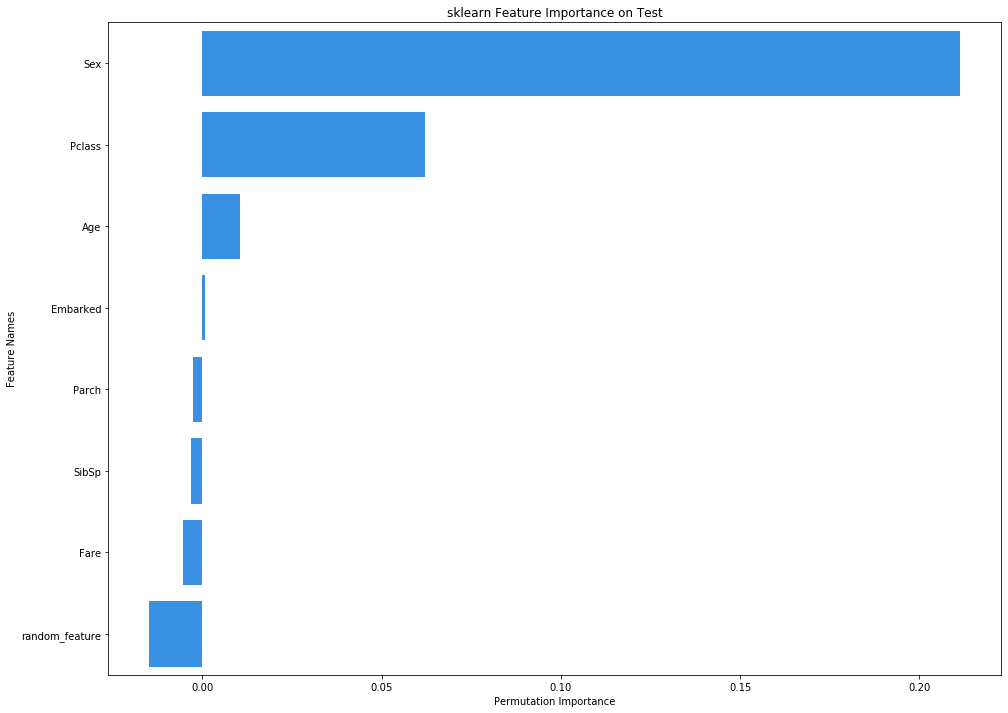

In [25]:
# вызов функции permutation_plot отрисовывает топ важности по методу permutation importance

perm_imp.permutation_plot(figsize=(16,12), top=10)

#### Вызов функции select_features выдает список отобранных признаков. 

* Отбор происходит следующим образом:
    * Если на тестовом множестве значение метрики относительно перемешанного факторо и рандомного признака ниже нуля, то отбираются все признаки выше нуля.
    * Если рандомный признак имеет положительное значение на тестовом множестве, то отбираются все признаки выше значения при рандомном признаке.

In [26]:
perm_imp.select_features()

8 признаков было до Permutation Importance 

4 признаков после Permutation Importance от sklearn


['Sex', 'Pclass', 'Age', 'Embarked']

### 3.2 От Eli5

In [27]:
%%time

# От Eli5

perm_imp.calculate_permutation(
    X_test=new_X_valid, 
    y_test=y_valid,
    
    n_iter=15,
    permute_type='eli5',
#   n_jobs=-1,
#   metric=roc_auc_score,
#   higher_is_better=True
)

CPU times: user 834 ms, sys: 73.1 ms, total: 907 ms
Wall time: 321 ms


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
Sex,0.237239,0.213930
Pclass,0.098020,0.074129
Age,0.059711,0.020896
Fare,0.040556,0.008955
Parch,0.033387,0.006716
SibSp,0.024612,0.004975
Embarked,0.015837,0.003234
random_feature,0.031996,-0.004229


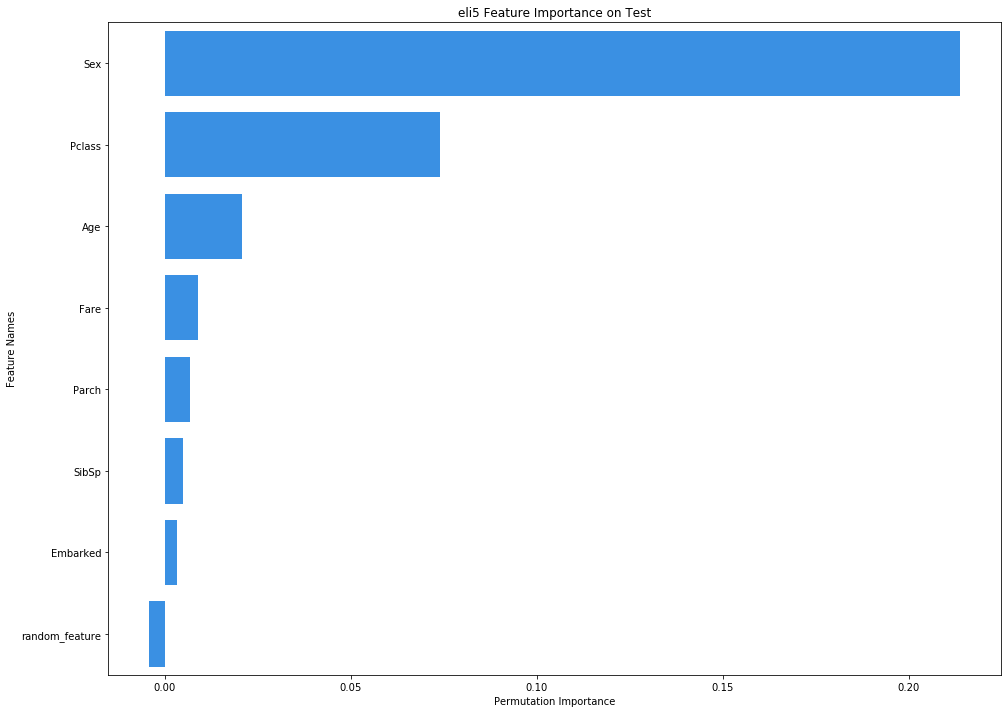

In [28]:
perm_imp.permutation_plot(figsize=(16,12), top=10)

In [29]:
perm_imp.select_features()

8 признаков было до Permutation Importance 

7 признаков после Permutation Importance от eli5


['Sex', 'Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'Embarked']

### 3.3 Самописный permutation kib

In [30]:
%%time

# Самописный permutation

perm_imp.calculate_permutation(
    X_test=new_X_valid, 
    y_test=y_valid,
    
    n_iter=15,
    permute_type='kib',
    n_jobs=-1,
    metric=roc_auc_score,
    higher_is_better=True)

Расчет Permutation Importance на Train


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 6150.01it/s]


Расчет Permutation Importance на Test


100%|██████████████████████████████████████████| 8/8 [00:00<00:00, 11019.52it/s]

CPU times: user 39.6 ms, sys: 7.84 ms, total: 47.4 ms
Wall time: 172 ms


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
Sex,0.229536,0.245558
Pclass,0.067562,0.060257
Fare,0.049521,0.030833
Age,0.051122,0.029346
Parch,0.019847,0.015275
SibSp,0.014100,0.002773
Embarked,0.014272,0.002448
random_feature,0.028006,0.001793


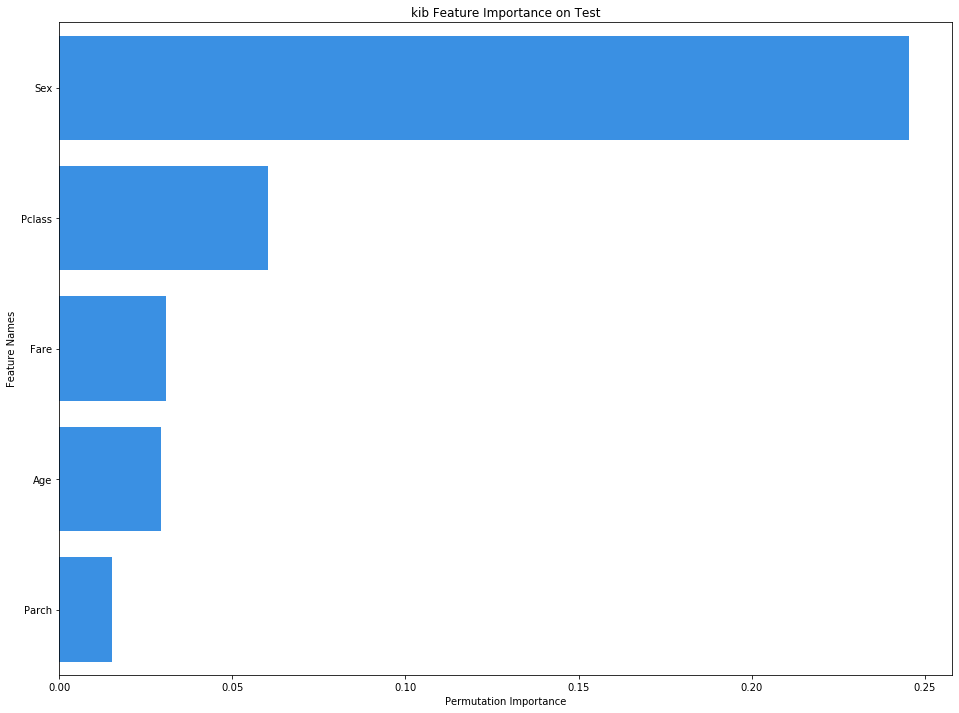

In [31]:
perm_imp.permutation_plot(figsize=(16,12), top=5)

In [32]:
perm_imp.select_features()

8 признаков было до Permutation Importance 

7 признаков после Permutation Importance от kib


['Sex', 'Pclass', 'Fare', 'Age', 'Parch', 'SibSp', 'Embarked']